![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.png)

# Automated Machine Learning:  Forecasting Stack Overflow Volume

## Introduction

In this example we use modified Stack Overflow Volume dataset to showcase how you can use AutoML for a simple forecasting problem and explore the results. The goal is predict each Azure team's stack overflow question volume for the next 7 days based on historic time-series data.

In [1]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime
from azureml.explain.model._internal.explanation_client import ExplanationClient
from azureml.train.automl.run import AutoMLRun
remote_run = AutoMLRun(experiment=experiment, run_id='AutoML_8cbe242f-5f80-4e94-b3f3-4a3493e66e20')

ws = Workspace.from_config()
experiment_name = 'automl-forecasting-stackoverflow'
experiment = Experiment(ws, experiment_name)

In [7]:
ws.compute_targets['cpu-cluster']

AmlCompute(workspace=Workspace.create(name='Bert-Demo', subscription_id='15ae9cb6-95c1-483d-a0e3-b1a1a3b06324', resource_group='e2eworkshop'), name=cpu-cluster, id=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/e2eworkshop/providers/Microsoft.MachineLearningServices/workspaces/Bert-Demo/computes/cpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=eastus, tags=None)

Let's set up what we know about the dataset.

<b>Target column</b> is what we want to forecast.<br></br>
<b>Time column</b> is the time axis along which to predict. <br>
<b>Time-series identifier(s)</b> are the columns which uniquely identify time-series in your data

In [6]:
target_column_name = 'volume'
time_column_name = 'date'
time_series_id_column_names = 'team_tag'

In [7]:
train_dataset = Dataset.Tabular.from_delimited_files(path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/ForecastingDemo/azure_support_volume_timeseries_train.csv").with_timestamp_columns(fine_grain_timestamp=time_column_name) 
test_dataset = Dataset.Tabular.from_delimited_files(path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/ForecastingDemo/azure_support_volume_timeseries_test.csv").with_timestamp_columns(fine_grain_timestamp=time_column_name) 

train_dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,date,team_tag,volume
0,2020-03-01,azure-devops,39
1,2020-03-02,azure-devops,151
2,2020-03-03,azure-devops,165
3,2020-03-04,azure-devops,294
4,2020-03-05,azure-devops,271


### Setting the maximum forecast horizon

The forecast horizon is the number of periods into the future that the model should predict. 

In this example, we set the horizon to 7 days.

In [9]:
max_horizon = 7

This notebook uses the blacklist_models parameter to exclude some models that take a longer time to train on this dataset. You can choose to remove models from the blacklist_models list but you may need to increase the experiment_timeout_hours parameter value to get results.

In [10]:
automl_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    'grain_column_names': time_series_id_column_names
}

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blacklist_models = ['ExtremeRandomTrees', 'Prophet'],                             
                             experiment_timeout_hours=0.25,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=2,                             
                             verbosity=logging.INFO,
                            **automl_settings)

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while.
One may specify `show_output = True` to print currently running iterations to the console.

In [12]:
remote_run = experiment.submit(automl_config)

Running on remote or ADB.


In [10]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Retrieve the Best Model
Below we select the best model from all the training iterations using get_output method.

In [13]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None, logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('0', Pipeline(memory=None,
       steps=[('autoarima', <azureml.automl.runtime.shared.forecasting_models.AutoArima object at 0x7f6454df3e10>)])), ('7', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at...ators=25, n_jobs=1,
             oob_score=False, random_state=None, verbose=0, warm_start=False))]))],
                 flatten_transform=None,
                 weights=[0.9166666666666666, 0.08333333333333333]))]

## Featurization
You can access the engineered feature names generated in time-series featurization.

In [14]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['grain_team_tag', 'quarter', 'day', 'wday', 'qday', 'yday', 'week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

+ Raw feature name
+ Number of engineered features formed out of this raw feature
+ Type detected
+ If feature was dropped
+ List of feature transformations for the raw feature

In [15]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,Yes,1,team_tag,[GrainMarker-LabelEncoder],Ignore
1,No,6,date,"[DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer]",DateTime


## Retrieve the Best Model's explanation
Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. Make sure that the run for generating explanations for the best model is completed.

In [16]:
# Wait for the best model explanation run to complete
from azureml.core.run import Run
model_explainability_run_id = remote_run.get_properties().get('ModelExplainRunId')
print(model_explainability_run_id)
if model_explainability_run_id is not None:
    model_explainability_run = Run(experiment=experiment, run_id=model_explainability_run_id)
    model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

AutoML_8cbe242f-5f80-4e94-b3f3-4a3493e66e20_ModelExplain


In [17]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'grain_team_tag': 47.49837012325396,
 'wday': 35.59066836850535,
 'day': 3.5734735006523834,
 'qday': 1.9643888895700974,
 'yday': 1.0993477319248512,
 'week': 0.0,
 'quarter': 0.0}

In [18]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'team_tag': 47.49837012325396, 'date': 42.22787849065268}

## Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:

In [19]:
test = test_dataset.to_pandas_dataframe().reset_index(drop=True)
y_test = test.pop(target_column_name).values
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(test)

### Evaluate
To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [21]:
from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, test, y_test, target_column_name)

[Test data scores]

mean_absolute_percentage_error:   148.952
mean_absolute_error:   19.625
root_mean_squared_log_error:   0.732
normalized_root_mean_squared_error:   0.095
spearman_correlation:   0.857
root_mean_squared_error:   29.016
normalized_median_absolute_error:   0.038
normalized_mean_absolute_error:   0.064
median_absolute_error:   11.505
explained_variance:   0.886
r2_score:   0.882
normalized_root_mean_squared_log_error:   0.158


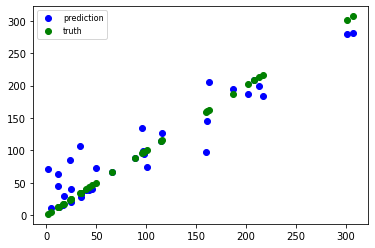

In [22]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl metrics module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

Looking at `X_trans` is also useful to see what featurization happened to the data.

In [23]:
X_trans

,,grain_team_tag,quarter,day,wday,qday,yday,week,_automl_target_col
date,team_tag,,,,,,,,
2020-04-04,azure-devops,0,2,4,5,4,95,14,106.17
2020-04-05,azure-devops,0,2,5,6,5,96,14,71.68
2020-04-06,azure-devops,0,2,6,0,6,97,15,114.36
2020-04-07,azure-devops,0,2,7,1,7,98,15,205.64
2020-04-08,azure-devops,0,2,8,2,8,99,15,280.27
2020-04-09,azure-devops,0,2,9,3,9,100,15,281.73
2020-04-10,azure-devops,0,2,10,4,10,101,15,209.29
2020-04-04,azure-storage,2,2,4,5,4,95,14,85.10
2020-04-05,azure-storage,2,2,5,6,5,96,14,40.26


Review explanation dashboard at [https://ml.azure.com/experiments/id/315692f8-5d45-4e02-a946-e606b4e71836/runs/AutoML_8cbe242f-5f80-4e94-b3f3-4a3493e66e20_8?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/e2eworkshop/workspaces/Bert-Demo&tid=72f988bf-86f1-41af-91ab-2d7cd011db47#explanations](https://ml.azure.com/experiments/id/315692f8-5d45-4e02-a946-e606b4e71836/runs/AutoML_8cbe242f-5f80-4e94-b3f3-4a3493e66e20_8?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/e2eworkshop/workspaces/Bert-Demo&tid=72f988bf-86f1-41af-91ab-2d7cd011db47#explanations)